In this assignment, our goal is to predict prices of houses solf in the US.
Since this is a prediction problem, we will use methods such as linear regression and neural netowks.

First we load the packages we are gonna need, and then load the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\annaa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load train data
df_train = pd.read_csv('../house-prices-advanced-regression-techniques/train.csv')
df_train.shape

(1460, 81)

The dataset consists of 81 variables and  rows. Out of the columns, the last one is tha target (SalePrice). Also, there is a column named 'Id'. It represents the number of each sample row, and therefore it is not expected to give any information about the target variable.

We want to get a first feel of the relationships among the variables. Thus, we plot the correlation matrix.

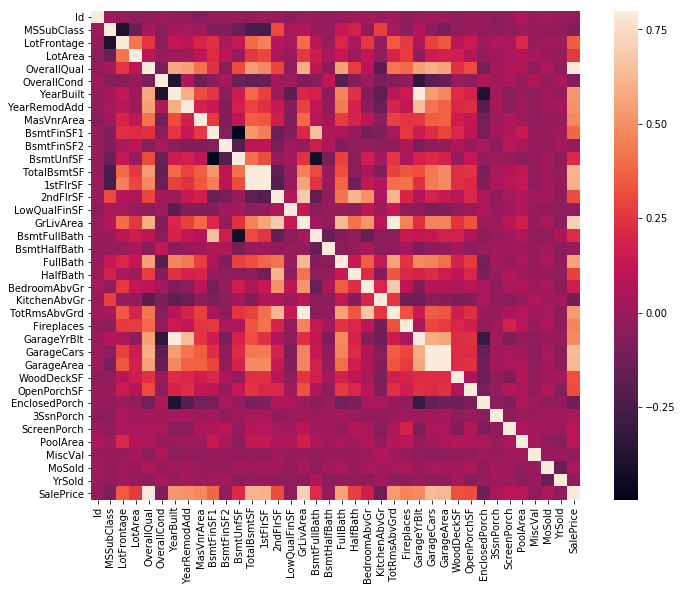

In [3]:
#first we have to take a look at the data
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

As we can see, the (linear) correlation between two variables can either be positive or negative. Although there are high positive correlations, the negative correlations are not that strong. In our plot, the darker the square, the lower the correlation. Also, the brighter the square, the higher the correlation.

Notice that the correlations related to our target variable, SalePrice, seem to be mostly positive. Also, notice that there are strong relationships among the predictors themselves. Some of them are to be expected, such as basement1 squared feet is highly related with total square feet of basement. We expect feature selection techniques to recognize the relationships and only keep one of the correlated prodictors, if chosen.

The variables that are most highly correlated with SalePrice, are OverallQual, GrLivArea and GarageCars.

In [4]:
corrmat.abs().unstack()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float

The dataset contains missing values. We sorted the variables according to the percentage of missing values.

In [5]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Many of the missing values can be explained through the data description file. Thus, we replace the missing values with the default value. The only case we cold not replace the missing value is for the 'Electrical' variable. However, there is only one sample without a value, so we felt free to simply delete the row.

In [6]:
#Since PCA cannot handle missing values, we should impute or delete entire columns/rows
#First, we replace the missing values that are explained in the variable descriptions
# PoolQC : data description says NA means "no pool"
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("No")
# MiscFeature : data description says NA means "None"
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("None")
# Alley : data description says NA means "no alley"
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("No")
# Fence : data description says NA means "no fence"
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("No")
## Start of garage missing values, probably they are on the same houses
# GarageCond : data description says NA means "no garage"
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("No")
# GarageType : data description says NA means "no garage"
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("No")
# GarageFinish : data description says NA means "no garage"
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("No")
# GarageQual : data description says NA means "no garage"
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("No")
##Probably missing values in basement features refer to the same rows too
# BsmtExposure : data description says NA means "no basement"
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("NoBasement")
# BsmtFinType2 : data description says NA means "no basement"
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("NoBasement")
# BsmtFinType1 : data description says NA means "no basement"
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("NoBasement")
# BsmtCond : data description says NA means "no basement"
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("NoBasement")
# BsmtQual : data description says NA means "no basement"
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("NoBasement")
# MasVnrType : data description says NA should mean "none"
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")

#In 'Electrical' we'll just delete the observation with missing data.
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

Also, we cannot fill in the missing values for the variables 'LotFrontage', 'GarageYrBlt' and 'MasVnrArea'. These variables are not highly correlated with 'SalePrice' and we do not expect them to be good predictors for it. Thus, we decided to delete the entire columns along with the 'Id', as explained before.

In [7]:
#Unexplained missing values
# LotFrontage : NA most likely means no lot frontage
#train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# GarageYrBlt ?????
# MasVnrArea ?????
#Since they seem not to be highly correlated with the target, maybe we should just drop the columns

df_train = df_train.drop(['Id','LotFrontage', 'GarageYrBlt', 'MasVnrArea'], axis=1)
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPor

In [8]:
#check that missing data no longer exist
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,0,0.0
BsmtQual,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
Foundation,0,0.0
BsmtCond,0,0.0


After the data cleansing process, we are left with 76 predictors and 1459 rows.

In [9]:
df_train.shape

(1459, 77)

Our dataset contains both categorical and numerical features. However, methods such as linear regression cannot handle categorical data. So, we have to convert categorical variables to numerical.

In [10]:
#linear regression can only handle numerical data
categorical_features = df_train.select_dtypes(include = ["object"]).columns
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns
#numerical_features = numerical_features.drop("SalePrice")
train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]
train_cat = pd.get_dummies(train_cat)
df_train_new = pd.concat([train_num, train_cat], axis = 1)

In [11]:
corr_data = df_train_new
#we have to split to train and valdation set, so that we can pick the best algorithm
y = df_train_new['SalePrice']
X = df_train_new.drop('SalePrice', axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In order to pick the best method, we have to train various methods, and then test their ability to predict the target variable. To do so, we have to split our dataset into two smaller sets, the training dataset and the validation dataset.

In [12]:
X_train = X.iloc[0:1022, :]
y_train = y.iloc[0:1022]
X_test = X.iloc[1022:1459, :]
y_test = y.iloc[1022:1459]

In [13]:
X_test.shape

(437, 299)

Next, we again plot the correlation matrix. This time it only contains the variables that have the highest correlation with 'SalePrice'.

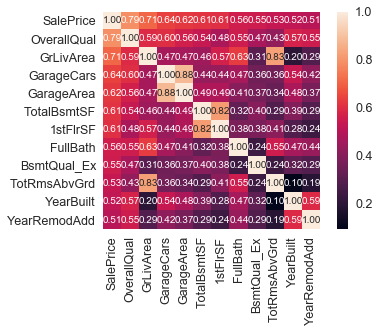

In [14]:
corrmat = corr_data.corr()

k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train_new[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#maybe we should just pick the ones with high correlation for training

In [15]:
corrmat.abs().unstack()['SalePrice'].sort_values(ascending=False)

SalePrice               1.000000
OverallQual             0.791069
GrLivArea               0.708618
GarageCars              0.640473
GarageArea              0.623423
TotalBsmtSF             0.613905
1stFlrSF                0.605968
ExterQual_TA            0.589082
FullBath                0.560881
BsmtQual_Ex             0.553093
TotRmsAbvGrd            0.533779
YearBuilt               0.523273
KitchenQual_TA          0.519600
YearRemodAdd            0.507430
KitchenQual_Ex          0.504080
Foundation_PConc        0.498083
FireplaceQu_No          0.471971
Fireplaces              0.466968
BsmtQual_TA             0.452626
ExterQual_Gd            0.452466
ExterQual_Ex            0.451152
BsmtFinType1_GLQ        0.434588
HeatingQC_Ex            0.434583
GarageFinish_Fin        0.420341
GarageFinish_Unf        0.410809
Neighborhood_NridgHt    0.402133
BsmtFinSF1              0.386436
MasVnrType_None         0.367450
SaleType_New            0.357489
GarageType_Detchd       0.354258
          

Linear regression is the method we focused on. We trained three different models, one using all the variables, one using only the top two and one using the top 10 variables.

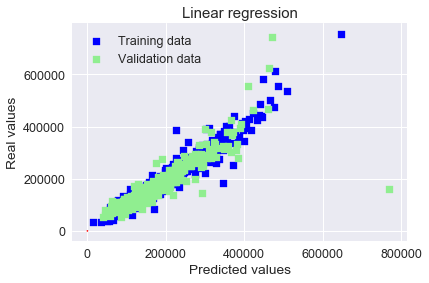

In [17]:
#linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

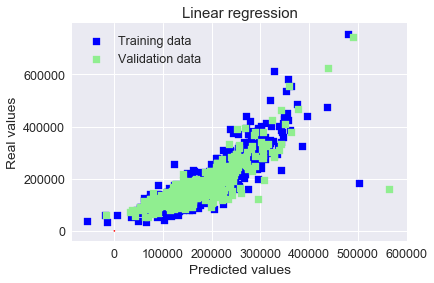

In [18]:
X_train[['OverallQual', 'GrLivArea']]
#linear regression
lr2 = LinearRegression()
lr2.fit(X_train[['OverallQual', 'GrLivArea']], y_train)
y_train_pred = lr2.predict(X_train[['OverallQual', 'GrLivArea']])
y_test_pred_2 = lr2.predict(X_test[['OverallQual', 'GrLivArea']])

plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_2, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Next, we weregoing to use the top 10 features to create a predictive model. But GarageArea is highly correlated with GarageCars, so we use only the one with the higher correlation with the target.
Same goes with with TotalBsmtSF and 1stFlrSF.
This leaves us with eight predictive vriables.

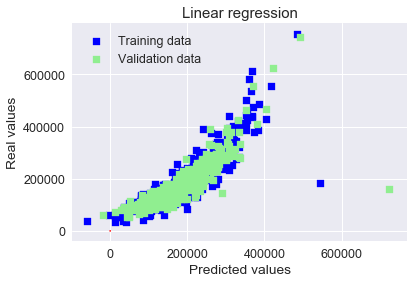

In [19]:
#train linear model with features having higher correlation over 0.5 with the target
X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']]
#linear regression
lr8 = LinearRegression()
lr8.fit(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']], y_train)
y_train_pred = lr8.predict(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
y_test_pred_8 = lr8.predict(X_test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])

plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_8, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In order to be able to fit non-linear relationships, we created polynomial features for each of the top 8 variables. The highest degree of the polynomials is 3.

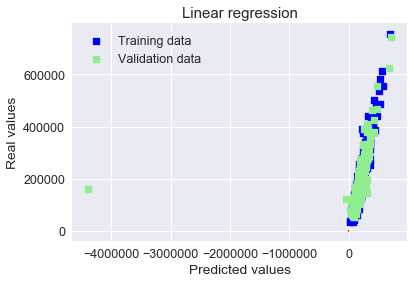

In [20]:
#fitting non-linear relationships
from sklearn.preprocessing import PolynomialFeatures

polynomial = PolynomialFeatures(degree = 3, include_bias = False)
X_train_poly = polynomial.fit_transform(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
X_test_poly = polynomial.transform(X_test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_train_pred_poly = lr_poly.predict(X_train_poly)
y_test_pred_poly = lr_poly.predict(X_test_poly)

plt.scatter(y_train_pred_poly, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_poly, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

We plotted the error of each mathod. As we can see, linear regression with polynomial features seems to do well, even though the mean squared error is higher. However, there seems to be a sample that, in all three cases, cannot be well predicted. This sample could be an outlier. Thus, we will go back to our data, and delete the values that can be considered as outliers. Then, we will train the same models again, and see if and how much they will improve.

In [27]:
print("Mean squared error using all features:")
print(mean_squared_error(y_test, y_test_pred))
print("Mean squared error using top two features:")
print(mean_squared_error(y_test, y_test_pred_2))
print("Mean squared error using top eight features:")
print(mean_squared_error(y_test, y_test_pred_8))
print("Mean squared error using polynomial features of top eight features:")
print(mean_squared_error(y_test, y_test_pred_poly))

Mean squared error using all features:
1655956852.1715164
Mean squared error using top two features:
2076862086.5664139
Mean squared error using top eight features:
1966341330.2337375
Mean squared error using polynomial features of top eight features:
48512495306.91488


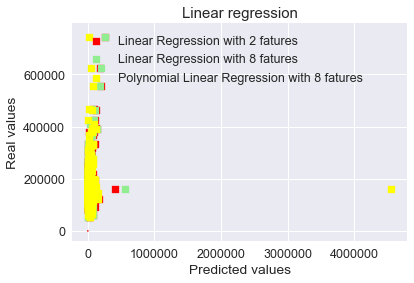

In [24]:
plt.scatter(abs(y_test-y_test_pred_2), y_test, c = "red", marker = "s", label = "Linear Regression with 2 fatures")
plt.scatter(abs(y_test-y_test_pred_8), y_test, c = "lightgreen", marker = "s", label = "Linear Regression with 8 fatures")
plt.scatter(abs(y_test-y_test_pred_poly), y_test, c = "yellow", marker = "s", label = "Polynomial Linear Regression with 8 fatures")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

We will delete the samples that seem to be outliers.

In [35]:
#deleting points
corr_data = corr_data.drop(corr_data.sort_values(by = 'GrLivArea', ascending = False)[:2].index)
corr_data.shape

(1457, 300)

In [36]:
y = corr_data['SalePrice']
X = corr_data.drop('SalePrice', axis=1)
X_train = X.iloc[0:1022, :]
y_train = y.iloc[0:1022]
X_test = X.iloc[1022:1457, :]
y_test = y.iloc[1022:1457]

In [38]:
#linear regreassion with all features
lr_new = LinearRegression()
lr_new.fit(X_train, y_train)
y_train_pred = lr_new.predict(X_train)
y_test_pred = lr_new.predict(X_test)

#linear regression wih two features
lr2_new = LinearRegression()
lr2_new.fit(X_train[['OverallQual', 'GrLivArea']], y_train)
y_train_pred = lr2_new.predict(X_train[['OverallQual', 'GrLivArea']])
y_test_pred_2 = lr2_new.predict(X_test[['OverallQual', 'GrLivArea']])

#linear regression wih eight features
lr8_new = LinearRegression()
lr8_new.fit(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']], y_train)
y_train_pred = lr8_new.predict(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
y_test_pred_8 = lr8_new.predict(X_test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])

#polynomial linear regression wih eight features
polynomial = PolynomialFeatures(degree = 3, include_bias = False)
X_train_poly = polynomial.fit_transform(X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
X_test_poly = polynomial.transform(X_test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
lr_poly_new = LinearRegression()
lr_poly_new.fit(X_train_poly, y_train)
y_train_pred_poly = lr_poly_new.predict(X_train_poly)
y_test_pred_poly = lr_poly_new.predict(X_test_poly)

In [39]:
print("After the deletion of possible outliers")
print("Mean squared error using all features:")
print(mean_squared_error(y_test, y_test_pred))
print("Mean squared error using top two features:")
print(mean_squared_error(y_test, y_test_pred_2))
print("Mean squared error using top eight features:")
print(mean_squared_error(y_test, y_test_pred_8))
print("Mean squared error using polynomial features of top eight features:")
print(mean_squared_error(y_test, y_test_pred_poly))

After the deletion of possible outliers
Mean squared error using all features:
765389462.3729566
Mean squared error using top two features:
1722179539.4299495
Mean squared error using top eight features:
1223607506.3905666
Mean squared error using polynomial features of top eight features:
1034797470.7280167


As we can see, afterremoving the two outliers, the mean squared errors dropped and the method using the polynomial features is the best.

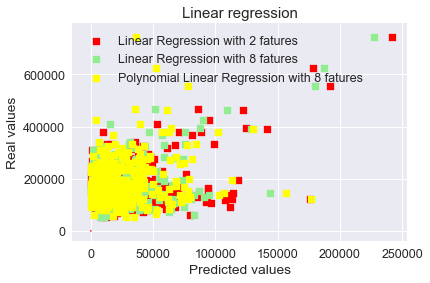

In [41]:
plt.scatter(abs(y_test-y_test_pred_2), y_test, c = "red", marker = "s", label = "Linear Regression with 2 fatures")
plt.scatter(abs(y_test-y_test_pred_8), y_test, c = "lightgreen", marker = "s", label = "Linear Regression with 8 fatures")
plt.scatter(abs(y_test-y_test_pred_poly), y_test, c = "yellow", marker = "s", label = "Polynomial Linear Regression with 8 fatures")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

With our model being selected, all we have to do is to use iton the test data. We load the test data, and treat them with the same data cleaning process as we didwith the training data.

In [54]:
#import test set and run models and RMSE on them
#load test data
df_test = pd.read_csv('../house-prices-advanced-regression-techniques/test.csv')
df_test.columns    #(1459, 80)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [50]:
#First, we replace the missing values that are explained in the variable descriptions
# PoolQC : data description says NA means "no pool"
df_test.loc[:, "PoolQC"] = df_test.loc[:, "PoolQC"].fillna("No")
# MiscFeature : data description says NA means "None"
df_test.loc[:, "MiscFeature"] = df_test.loc[:, "MiscFeature"].fillna("None")
# Alley : data description says NA means "no alley"
df_test.loc[:, "Alley"] = df_test.loc[:, "Alley"].fillna("No")
# Fence : data description says NA means "no fence"
df_test.loc[:, "Fence"] = df_test.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
df_test.loc[:, "FireplaceQu"] = df_test.loc[:, "FireplaceQu"].fillna("No")
## Start of garage missing values, probably they are on the same houses
# GarageCond : data description says NA means "no garage"
df_test.loc[:, "GarageCond"] = df_test.loc[:, "GarageCond"].fillna("No")
# GarageType : data description says NA means "no garage"
df_test.loc[:, "GarageType"] = df_test.loc[:, "GarageType"].fillna("No")
# GarageFinish : data description says NA means "no garage"
df_test.loc[:, "GarageFinish"] = df_test.loc[:, "GarageFinish"].fillna("No")
# GarageQual : data description says NA means "no garage"
df_test.loc[:, "GarageQual"] = df_test.loc[:, "GarageQual"].fillna("No")
##Probably missing values in basement features refer to the same rows too
# BsmtExposure : data description says NA means "no basement"
df_test.loc[:, "BsmtExposure"] = df_test.loc[:, "BsmtExposure"].fillna("NoBasement")
# BsmtFinType2 : data description says NA means "no basement"
df_test.loc[:, "BsmtFinType2"] = df_test.loc[:, "BsmtFinType2"].fillna("NoBasement")
# BsmtFinType1 : data description says NA means "no basement"
df_test.loc[:, "BsmtFinType1"] = df_test.loc[:, "BsmtFinType1"].fillna("NoBasement")
# BsmtCond : data description says NA means "no basement"
df_test.loc[:, "BsmtCond"] = df_test.loc[:, "BsmtCond"].fillna("NoBasement")
# BsmtQual : data description says NA means "no basement"
df_test.loc[:, "BsmtQual"] = df_test.loc[:, "BsmtQual"].fillna("NoBasement")
# MasVnrType : data description says NA should mean "none"
df_test.loc[:, "MasVnrType"] = df_test.loc[:, "MasVnrType"].fillna("None")
# GarageCars : data description says NA should mean "none"
df_test.loc[:, "GarageCars"] = df_test.loc[:, "GarageCars"].fillna(0)
# GarageCars : data description says NA should mean "none"
df_test.loc[:, "TotalBsmtSF"] = df_test.loc[:, "TotalBsmtSF"].fillna(0)

df_test = df_test.drop(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], axis=1)

In [48]:
#missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MSZoning,4,0.002742
Functional,2,0.001371
BsmtHalfBath,2,0.001371
Utilities,2,0.001371
BsmtFullBath,2,0.001371
KitchenQual,1,0.000685
BsmtFinSF1,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
GarageCars,1,0.000685


In [52]:
vars_poly = polynomial.transform(df_test[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd']])
predictions = lr_poly_new.predict(vars_poly)
predictions

array([121615.46248943, 156105.98753804, 176254.37562197, ...,
       143055.65122133, 111154.87633604, 222063.5441224 ])

In [60]:
#Save predictions to csv
#dataset = pd.DataFrame(data = predictions[:,1])
#predictions.to_csv('../house-prices-advanced-regression-techniques/submission.csv')

IndexError: too many indices for array